<a href="https://colab.research.google.com/github/coder-penguin/ML/blob/master/tutorial/scikit_learn_tutorial_hpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sample code for hyper parameter tuning

Load libraries

In [0]:
!pip install optuna

     |████████████████████████████████| 153kB 4.7MB/s 
     |████████████████████████████████| 1.1MB 44.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 11.8MB/s 
     |████████████████████████████████| 81kB 12.3MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 112kB 54.5MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=4b343d3906213ff98448b46f2c7cc623ead4e850c276357727cb57a3956d7a21
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-1.2.0-cp36-none-any.whl size=204611 sha256=15c88528b0d10e573bb35931bb538232c42174269eb76bc186af414bd90d4246
  Stored in directory: /root/.cache/pip/wheels/74

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.externals import joblib

from hyperopt import fmin, tpe, hp, rand, Trials
from hyperopt.pyll.base  import scope
import optuna

Read data

In [0]:
# read the breast cancer wisconsin dataset
dataset = load_breast_cancer()

In [0]:
#30 features
dataset['data'].shape

(569, 30)

In [0]:
#binary target
dataset['target']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [0]:
dataset['target_names']

array(['malignant', 'benign'], dtype='<U9')

In [0]:
dataset['feature_names']

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

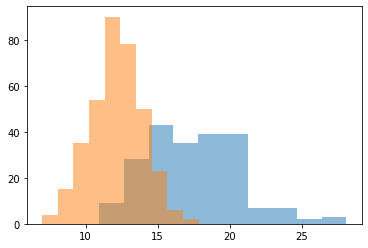

In [0]:
# show data
plt.hist(dataset['data'][:, 0][dataset['target']==0], label=dataset['target_names'][0], alpha=0.5)
plt.hist(dataset['data'][:, 0][dataset['target']==1], label=dataset['target_names'][1], alpha=0.5)
plt.show()

In [0]:
# image(numpy.ndarray)
X = dataset.data

# label(numpy.ndarray)
y = dataset.target

In [0]:
#split dataset to train and test dataset
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)#default is True

In [0]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

455 114
455 114


###Hyper parameter tuning

GridSearchCV

In [0]:
param_grid = [{'n_estimators' : [10, 100, 500],
                       'max_depth' : [2, 4, 6, 8, 10]}]

In [0]:
model = RandomForestClassifier()

In [0]:
grid_search = GridSearchCV(model, param_grid, cv=3)

In [0]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [0]:
grid_search.best_params_

{'max_depth': 8, 'n_estimators': 10}

In [0]:
grid_search.best_score_

0.9604682235389799

RandomizedSearchCV

In [0]:
# specify parameters and distributions to sample from
param_dist = [{'n_estimators': range(10, 500),
                      'max_depth': range(1, 10)}]

n_iter_search = 100

In [0]:
model = RandomForestClassifier()

In [0]:
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=n_iter_search, cv=3)

In [0]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [0]:
random_search.best_params_

{'max_depth': 9, 'n_estimators': 87}

In [0]:
random_search.best_score_

0.9604682235389799

hyperopt

In [0]:
def objective_hyperopt(args):
        
    cv = 3
    model = RandomForestClassifier(**args)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

    return 1 - scores.mean()

In [0]:
param_hyperopt = {'n_estimators': scope.int(hp.quniform('n_estimators',  10, 500, q=1)),
                               'max_depth': scope.int(hp.quniform('max_depth', 1, 10,  q=1))}

In [0]:
trials = Trials()
best = fmin(objective_hyperopt, param_hyperopt, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [02:02<00:00,  1.23s/it, best loss: 0.04173928197978383]


In [0]:
best

{'max_depth': 6.0, 'n_estimators': 70.0}

In [0]:
1 - trials.best_trial['result']['loss']

0.9582607180202162

optuna

In [0]:
def objective_optuna(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 1, 10)
        
    cv = 3
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    return 1 - scores.mean()

In [0]:
study = optuna.create_study()

In [0]:
study.optimize(objective_optuna, n_trials=100)

In [0]:
study.best_params

{'max_depth': 6, 'n_estimators': 89}

In [0]:
1- study.best_value

0.9582752410828395

###Train model

In [0]:
model = RandomForestClassifier(n_estimators=87, max_depth=9)

In [0]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=87,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

###Evaluation

k-th cross validation

In [0]:
#k-th cross validation
cv = 3 #the number of foldings
cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')

array([0.93421053, 0.95394737, 0.9602649 ])

confusion matrix

In [0]:
#calculate confusion matrix
y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)
conf_mx = confusion_matrix(y_train, y_train_pred)

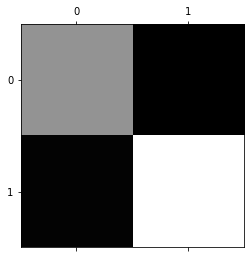

In [0]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

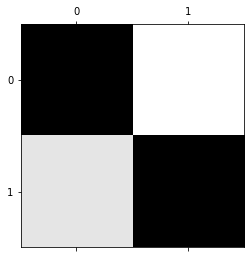

In [0]:
#convert to error probability
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
#set diagonal to 0 for visibility
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

various scores

In [0]:
accuracy_score(y_train, y_train_pred)

0.9560439560439561

In [0]:
precision_score(y_train, y_train_pred)

0.9715302491103203

In [0]:
recall_score(y_train, y_train_pred)

0.9578947368421052

In [0]:
f1_score(y_train, y_train_pred)

0.9646643109540636

In [0]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       170
           1       0.97      0.96      0.96       285

    accuracy                           0.96       455
   macro avg       0.95      0.96      0.95       455
weighted avg       0.96      0.96      0.96       455



In [0]:
y_train_probas = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')

In [0]:
y_train_scores = y_train_probas[:, 1]

In [0]:
def plot_pr_curve(y, y_score, label=None):

    fpr, tpr, thresholds = precision_recall_curve(y, y_score)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    return

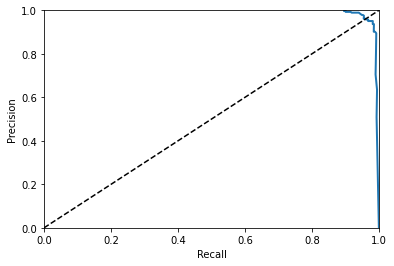

In [0]:
plot_pr_curve(y_train, y_train_scores)
plt.show()

In [0]:
def plot_roc_curve(y, y_score, label=None):

    fpr, tpr, thresholds = roc_curve(y, y_score)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    return

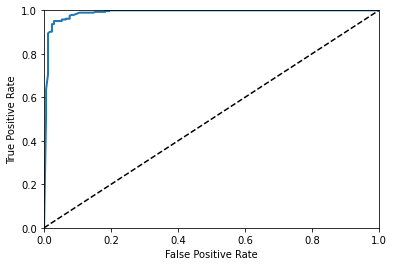

In [0]:
plot_roc_curve(y_train, y_train_scores)
plt.show()

In [0]:
roc_auc_score(y_train, y_train_scores)

0.9887512899896801

###Test

In [0]:
y_test_pred = model.predict(X_test)

In [0]:
accuracy_score(y_test, y_test_pred)

0.9298245614035088

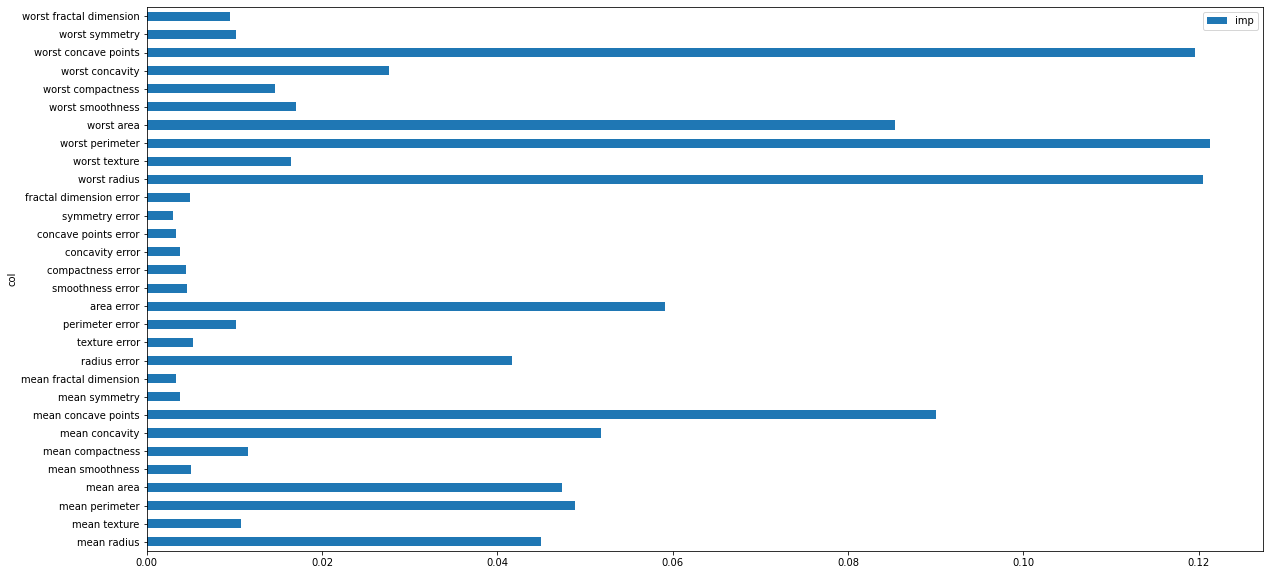

In [0]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': dataset['feature_names']})
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))

###Save

In [0]:
#save the prediction
submissiondir = '.'
submissionname = 'submission'
pd.DataFrame(data={'target':y_test, 'prediction':y_test_pred}).to_csv(submissiondir + '/' + submissionname + ".csv", index_label=["Id"])

In [0]:
# save the model
filename = 'model.sav'
joblib.dump(model, filename)

['model.sav']

In [0]:
# load the model
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.9035087719298246
